### Libraries

In [35]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from pyDOE import lhs
from torch import tensor
import torch.nn as nn

### Parameters

In [36]:
torch.set_default_dtype(torch.double)
num_epochs = 20000
lr = 1e-3
test_freq = 50
X_domain = [-1, 1]    # we solve the problem in this domain
T_domain = [0, 1]
lb = [X_domain[0], T_domain[0]]  # the lower and upper bound of the domain
ub = [X_domain[-1], T_domain[-1]]
num_domain = 2000  # number of training collocation data points inside the domain
num_initial_boundary = 100  # number of training data point from initial and boundry data
num_x_total = 200 # number of all the data points along 'x'
num_t_total = 100 # number of all the data points along 't'
gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Diffusion equation

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

### Initial Condition:

$$y(x,0)=sin(\pi x)$$

### Exact solution:

$$y(x,t)=e^{-t}sin(\pi x)$$


# Generating Data

In [37]:
x = torch.linspace(X_domain[0],X_domain[-1],num_x_total) # generating all the 'x' points
t = torch.linspace(T_domain[0],T_domain[-1],num_t_total) # generating all the 't' points
x_grid, t_grid = torch.meshgrid(x, t, indexing = 'ij') # creating the grid data points from 'x' and 't' data
y_grid = torch.exp(-t_grid) * torch.sin(np.pi*x_grid) # creating the corresponding grid for the output data

In [38]:
# reshaping the data for feeding to the model
data_input_all = torch.hstack((x_grid.flatten().view(-1,1), t_grid.flatten().view(-1,1)))
data_output_all = y_grid.flatten().view(-1,1)

In [39]:
# selecting the desired number of data points from the whole data

data_input_initial = torch.hstack((x_grid[:,0].view(-1,1), t_grid[:,0].view(-1,1)))
data_output_initial = torch.sin(np.pi * x_grid[:,0]).view(-1,1)

data_input_boundary1 = torch.hstack((x_grid[0,:].view(-1,1), t_grid[0,:].view(-1,1)))
data_output_boundary1 = torch.sin(np.pi * x_grid[0,:]).view(-1,1)

data_input_boundary2 = torch.hstack((x_grid[-1,:].view(-1,1), t_grid[-1,:].view(-1,1)))
data_output_boundary2 = torch.sin(np.pi * x_grid[-1,:]).view(-1,1)

data_input_boundary_initial = torch.vstack([data_input_initial, data_input_boundary1, data_input_boundary2])
data_output_boundary_initial = torch.vstack([data_output_initial, data_output_boundary1, data_output_boundary2])

idx = np.random.choice(data_input_boundary_initial.shape[0], size=num_initial_boundary, replace=False)
x_BC_IC = data_input_boundary_initial[idx, :]
u_BC_IC = data_output_boundary_initial[idx, :]

x_col = tensor(lb) + (tensor(ub)-tensor(lb)) * lhs(x_BC_IC.shape[1], num_domain)
x_col = torch.vstack((x_col, x_BC_IC))

In [40]:
print(f"{x_BC_IC.shape[0]} boundary and initial points for initial and boundary loss.")
print(f"{x_col.shape[0]} collocation points inside the domain including boundaries for PDE loss.")

100 boundary and initial points for initial and boundary loss.
2100 collocation points inside the domain including boundaries for PDE loss.


In [41]:
class PhysicsInformedNet(nn.Module):
    def __init__(self):
        super(PhysicsInformedNet, self).__init__()

        self.net = nn.Sequential(        # defining the neural network
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
        )

        # Initialize weights using Xavier initialization and biases to zero
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

In [42]:
# Define the physics-based model
def PDE(x_col):
    
    x = x_col.clone()
    x.requires_grad = True
    u = model(x)
    u_x_u_t = torch.autograd.grad(u, x, grad_outputs = torch.ones(u.shape), create_graph=True)[0] # [0] element inside the tuple
    u_x, u_t = u_x_u_t[:, 0:1], u_x_u_t[:, 1:]
    u_xx_u_tt = torch.autograd.grad(u_x_u_t, x, grad_outputs = torch.ones(u_x_u_t.shape), create_graph=True)[0]
    u_xx = u_xx_u_tt[:, 0:1]
    
    return u_t - u_xx + torch.exp(-x[:, 1:]) * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))


# Define the loss function
def loss_func(x_col, x_BC_IC, u_BC_IC, model):
    u_pred = model(x_BC_IC)
    loss_BC_IC = F.mse_loss(u_pred, u_BC_IC)
    f_pred = PDE(x_col)
    loss_PDE = torch.mean(f_pred**2)
    loss = loss_PDE + loss_BC_IC 
    return loss

In [43]:
# creating the model object and the optimizer
model = PhysicsInformedNet()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [44]:
%%time
Loss_his = []
# Training the PINN
for i in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_func(x_col, x_BC_IC, u_BC_IC, model)
    loss.backward()
    optimizer.step()
    Loss_his.append(loss.detach().cpu().numpy())
    if i%(num_epochs/10)==0:
        print(f'Loss: {loss.detach().cpu().numpy()}')

Loss: 17.425516831371873
Loss: 0.0016613877687875409
Loss: 0.0008843972436816648
Loss: 0.0004860327767038775
Loss: 0.00019591519192893638
Loss: 0.00013370105652542525
Loss: 0.0001040955759567196
Loss: 0.00010163964909415795
Loss: 7.984681309231874e-05
Loss: 0.00011825703377374077
CPU times: user 16min 17s, sys: 17min 53s, total: 34min 10s
Wall time: 12min 17s


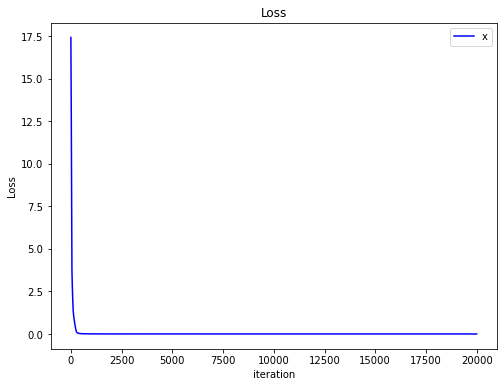

In [51]:
# plotting the Loss over iteration
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(np.array(Loss_his),'b-',label='x',)
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Ploting the results
### True solution

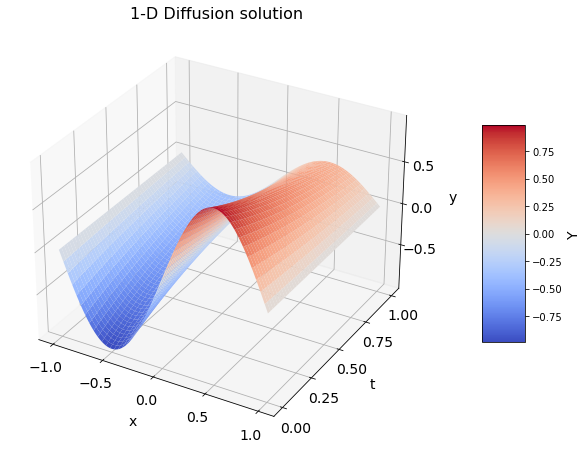

In [45]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x_grid, t_grid, y_grid, cmap='coolwarm', edgecolor='none')
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
ax.locator_params(axis='z', nbins=6)
colorbar = fig.colorbar(surf, shrink=0.5, aspect=5, pad=.1)


colorbar.set_label('Y', fontsize=14)

ax.set_xlabel('x', fontsize=14, labelpad=10)
ax.set_ylabel('t', fontsize=14, labelpad=10)
ax.set_zlabel('y', fontsize=14, labelpad=10)
ax.set_title('1-D Diffusion solution', fontsize=16)


plt.show()

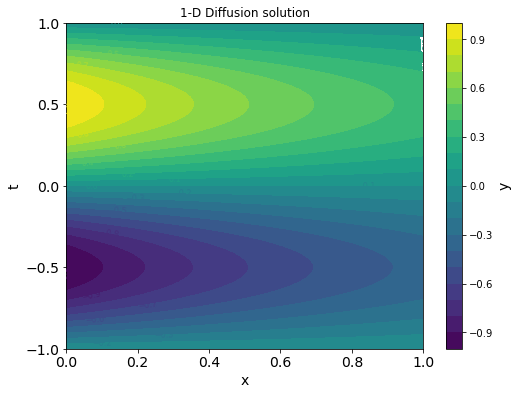

In [46]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, y_grid, levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Diffusion solution")
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("t", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

In [47]:
# using the train model to predict the solution
u_p = model(data_input_all)
u_p = u_p.view(num_x_total, num_t_total)

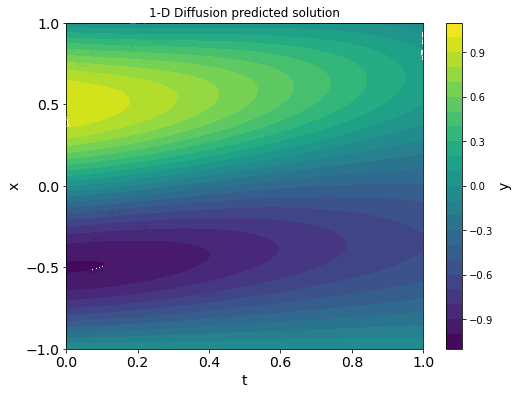

In [48]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, u_p.detach().cpu().numpy(), levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("1-D Diffusion predicted solution")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()

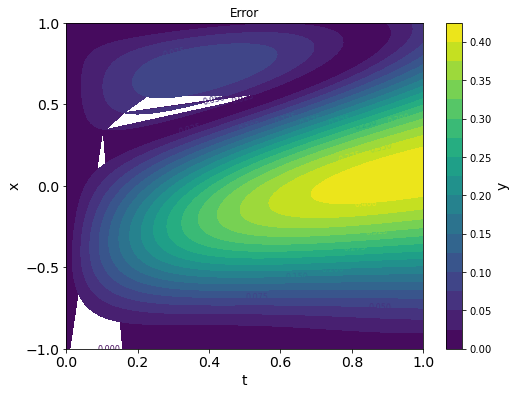

In [52]:
# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(t_grid, x_grid, np.abs(u_p.detach().cpu().numpy()-y_grid.detach().cpu().numpy()), levels=20)
ax.clabel(contour, inline=True, fontsize=8)
ax.tick_params(labelsize=14)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)

# Add a title and axis labels
ax.set_title("Error")
ax.set_xlabel("t", fontsize=14)
ax.set_ylabel("x", fontsize=14)

# Add a color bar
cbar = plt.colorbar(contour)
cbar.set_label("y", fontsize=14)

# Show the plot
plt.show()